In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# from sklearn import datasets


import torch
import torch.nn as nn
#import torch.nn.functional as F
#from torch.autograd import Variable
from torchsummary import summary
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,Dataset,random_split

from helper import fn_plot_torch_hist, fn_plot_confusion_matrix

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
inpDir = os.path.join( '..', 'input')
outDir = os.path.join('output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)


EPOCHS =50 # nos of epochs
ALPHA = 0.001 # learning 

BATCH_SIZE = 32
TRAIN_SIZE = 92*BATCH_SIZE ###(3670*0.8/32)
IMG_HEIGHT = 188
IMG_WIDTH = 188

## Early Stopping
PATIENCE = 20 # if performance does not improve stop
LR_FACTOR =0.1
LR_PATIENCE=10
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }
CMAP = 'coolwarm'
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

plt .rcParams.update(params)

<Figure size 1500x800 with 0 Axes>

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.version.cuda

'11.7'

In [5]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 2060 SUPER'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
### #in torch size of image is channel X width X height and in tf it is width X height X channel   in torch channels and in tf its is filter

## Helper functon

In [8]:
def fn_imshow(image, ax=None, title = None, normalize=True):
    if ax is None:
        fig,ax = plt.subplots()

    image = image.numpy().transpose((1,2,0))

    if normalize:
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = std*image + mean
        image = np.clip(image,0,1)   #0,1 is range to clip the image
    ax.imshow(image)

    #----little beautification----
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis = 'both',length=0)


    # # No tick labels
    # ax.set_xtickslabels('')
    # ax.set_ytickslabels('')
    return ax

In [9]:
transform =transforms.Compose([transforms.Resize(IMG_HEIGHT),transforms.CenterCrop(IMG_HEIGHT),
                               transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                               transforms.RandomRotation(degrees =(-45,45)),
                               transforms.ToTensor(),
                              transforms.Normalize(mean = np.array([0.485,0.456,0.406]),
                                                   std = np.array([0.229,0.224,0.225]))])
# '''
# You can add as many dataaugumentation as you want
# '''    

In [10]:
# import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = os.path.join('C:\\Users\\duasp\\input\\flower_photos')
dataset = datasets.ImageFolder(data_dir,transform=transform)

In [11]:
image, label = next(iter(dataset))

image.shape, label

(torch.Size([3, 188, 188]), 0)

In [12]:
dataset_size = len(dataset)
train_size = TRAIN_SIZE
test_size = dataset_size-train_size
print(train_size,test_size)

2944 726


In [13]:
train_dataset,test_dataset = random_split(dataset,[train_size,test_size])
len(train_dataset),len(test_dataset)

(2944, 726)

In [14]:
class_labels = {}
for k in train_dataset.dataset.class_to_idx:
    print(k, train_dataset.dataset.class_to_idx[k])
    class_labels[train_dataset.dataset.class_to_idx[k]]=k
class_labels

daisy 0
dandelion 1
roses 2
sunflowers 3
tulips 4


{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [15]:
#DataLoader?

In [16]:


trainloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,
                                          shuffle=True)#num_workers = 8)


testloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,
                                          shuffle=True)#num_workers = 8)

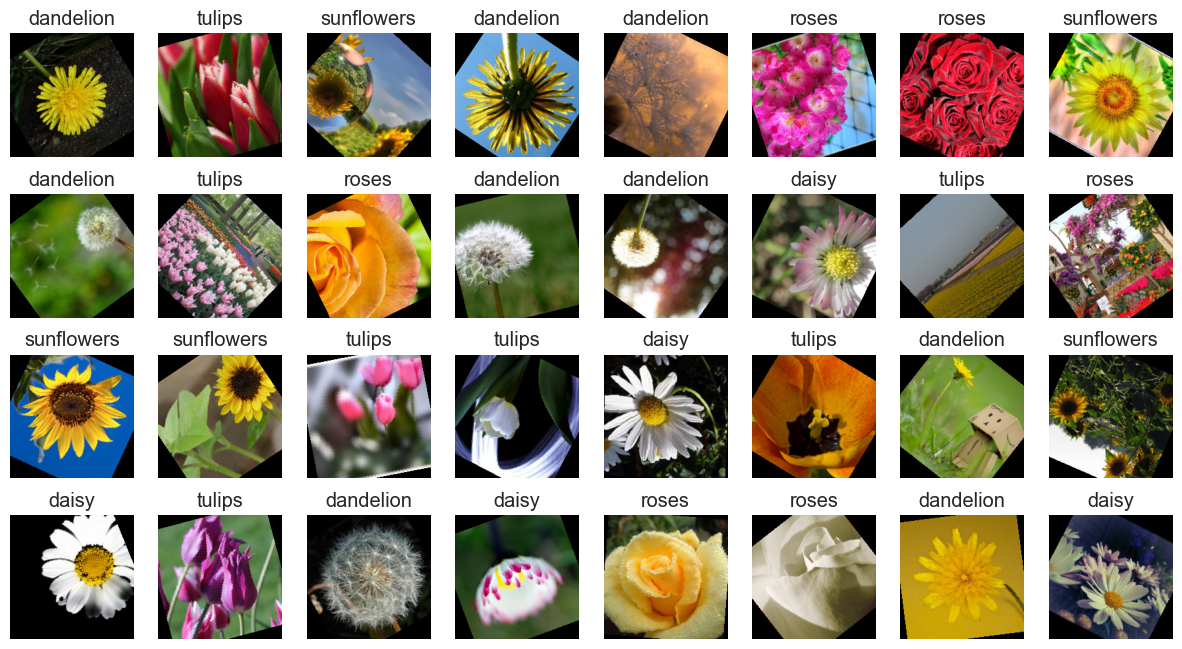

In [17]:
#image plot train set
images , labels = next(iter(trainloader))
#print(images.shape,labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range(BATCH_SIZE):
    ax= fig.add_subplot(BATCH_SIZE//8, 8,(i+1),xticks=[],yticks=[])
    fn_imshow(images[i], ax= ax, normalize = True)
    ax.set_title(class_labels[labels[i].item()])

In [18]:
trainloader.dataset #what is in dataset

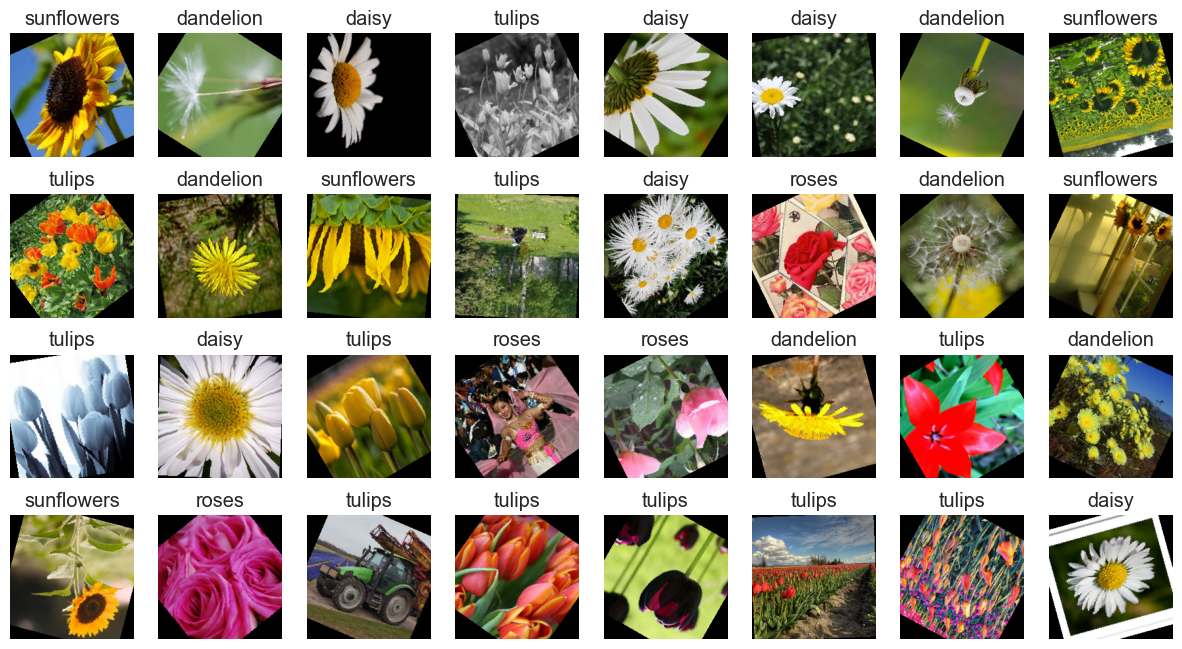

In [19]:
#image plot test set
images , labels = next(iter(testloader))
#print(images.shape,labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range(BATCH_SIZE):
    ax= fig.add_subplot(BATCH_SIZE//8, 8,(i+1),xticks=[],yticks=[])
    fn_imshow(images[i], ax= ax, normalize = True)
    ax.set_title(class_labels[labels[i].item()])

In [20]:
testloader.dataset #what is in dataset

In [21]:
numChannels = 3  #hard coding

numClasses = len(class_labels)

trainSteps = len(trainloader.dataset)// BATCH_SIZE

testSteps = len(testloader.dataset) // BATCH_SIZE

trainSteps,testSteps 


(92, 22)

### Define Model

In [22]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained = True)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.classifier.in_features
out_channels = 120

dor1 = 0.5

model = nn.Sequential(nn.Linear(num_ftrs, out_channels),
                      nn.ReLU(inplace = True),
                      nn.Dropout(p = dor1),
                      nn.Linear(in_features = out_channels, out_features = numClasses),
                      nn.LogSoftmax(dim = 1))

Using cache found in C:\Users\duasp/.cache\torch\hub\pytorch_vision_v0.10.0
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
'''
class LeNet(nn.Module):
    def __init__(self,numChannels,classes):
        #call parent's constructor
        super(LeNet, self).__init__()

        #Dropouts
        dor1 = 0.1
        dor2 = 0.15
        dor3 = 0.2
        dor4 = 0.25
        dor5 = 0.35
        dor6 = 0.40
        dor7 = 0.50
        #define Layers
    #-------### set 01###-------------        
        out_channels1 = 32

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv1 = nn.Conv2d(in_channels = numChannels,out_channels = out_channels1,
                               padding='same',bias=False,
                              kernel_size = (3,3))   ## output_shape = 188 x 188 x 32

        self.bn1 = nn.BatchNorm2d(out_channels1)
        
        self.actv1 = nn.SiLU()
        
        self.maxpool1= nn.MaxPool2d(kernel_size=(2,2),
                                    stride = (2,2))  ## output_shape = 94 x 94 x 32
        
        self.dropout1 = nn.Dropout(p=dor1)


        
        #-------### set 02###-------------        
        out_channels2 = 64

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv2 = nn.Conv2d(in_channels = out_channels1,out_channels = out_channels2,bias=False,
                              kernel_size = (3,3))   ## output_shape = 92 x 92 x 64

        self.bn2 = nn.BatchNorm2d(out_channels2)
        
        self.actv2 = nn.SiLU()
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2),
                                    stride = (2,2))  ## output_shape = 46 x 46 x 64
        
        self.dropout2 = nn.Dropout(p=dor2)



#-------### set 03###-------------        
        out_channels3 = 128

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv3 = nn.Conv2d(in_channels = out_channels2,out_channels = out_channels3,bias=False,
                              kernel_size = (3,3))   ## output_shape = 44 x 44 x 128

        self.bn3 = nn.BatchNorm2d(out_channels3)
        
        self.actv3 = nn.SiLU()
        
        self.maxpool3= nn.MaxPool2d(kernel_size=(2,2),
                                    stride = (2,2))  ## output_shape = 22 x 22 x 128
        
        self.dropout3 = nn.Dropout(p=dor3)



#-------### set 04###-------------        
        out_channels4 = 256

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv4 = nn.Conv2d(in_channels = out_channels3,
                               out_channels = out_channels4,bias=False,
                               kernel_size = (3,3))   ## output_shape = 20 x 20 x 256

        self.bn4 = nn.BatchNorm2d(out_channels4)
        
        self.actv4 = nn.SiLU()
        
        self.maxpool4= nn.MaxPool2d(kernel_size=(2,2),
                                    stride = (2,2))  ## output_shape = 10 x 10 x 256
        
        self.dropout4 = nn.Dropout(p=dor4)
        



#-------### set 05###-------------        
        out_channels5 = 512

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv5 = nn.Conv2d(in_channels = out_channels4,
                               out_channels = out_channels5,bias=False,
                               kernel_size = (3,3))   ## output_shape = 8 x 8 x 512

        self.bn5 = nn.BatchNorm2d(out_channels5)
        
        self.actv5 = nn.SiLU()
        
        self.maxpool5= nn.MaxPool2d(kernel_size=(2,2),
                                    stride = (2,2))  ## output_shape = 4 x 4 x 512
        
        self.dropout5 = nn.Dropout(p=dor5)



#-------### set 06###-------------        
        out_channels6 = 1024

        # Conv==> BN==>LeakyRelu==>Pool==>dropout
        self.conv6 = nn.Conv2d(in_channels = out_channels5,
                               out_channels = out_channels6,bias=False,
                               kernel_size = (3,3))   ## output_shape = 2 x 2 x 1024

        self.bn6 = nn.BatchNorm2d(out_channels6)
        
        self.actv6 = nn.SiLU()
        #self.dropout6 = nn.Dropout(p=dor6)


#-------### Head fully connected layers###-------------        
        out_channels7 = 128  #256/2

        # Linear==> BN==>LeakyRelu==>Pool==>dropout
        self.fc1 = nn.Linear(in_features = 2 * 2 * out_channels6,         #fc-fully connected     
                               out_features = out_channels7,bias=False
                               )   ## output_shape = 1 x 1 x 128
        self.bn7 = nn.BatchNorm1d(out_channels7)
        self.actv7 = nn.SiLU()
        self.dropout7 = nn.Dropout(p=dor7)


#-----------final output layer----------
        self.fc2 = nn.Linear(in_features =out_channels7,            
                               out_features = classes,bias=False)
                                  ## output_shape 128
        self.logsoftmax = nn.LogSoftmax(dim =1)



    def forward(self, x):
        #pass through 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x= self.maxpool1(x)
        x = self.dropout1(x)

        #pass through 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x= self.maxpool2(x)
        x = self.dropout2(x)

        #pass through 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.actv3(x)
        x= self.maxpool3(x)
        x = self.dropout3(x)
        
        #pass through 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.actv4(x)
        x= self.maxpool4(x)
        x = self.dropout4(x)

        #pass through 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.actv5(x)
        x= self.maxpool5(x)
        x = self.dropout5(x)

        #pass through 6
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.actv6(x)
        #x = self.dropout6(x)

        x = torch.flatten(x,1)

        #Head Fully connected
        x = self.fc1(x)
        x = self.bn7(x)
        x = self.actv7(x)
        x = self.dropout7(x)

        #output
        x = self.fc2(x)
        return self.logsoftmax(x)
        
'''

"\nclass LeNet(nn.Module):\n    def __init__(self,numChannels,classes):\n        #call parent's constructor\n        super(LeNet, self).__init__()\n\n        #Dropouts\n        dor1 = 0.1\n        dor2 = 0.15\n        dor3 = 0.2\n        dor4 = 0.25\n        dor5 = 0.35\n        dor6 = 0.40\n        dor7 = 0.50\n        #define Layers\n    #-------### set 01###-------------        \n        out_channels1 = 32\n\n        # Conv==> BN==>LeakyRelu==>Pool==>dropout\n        self.conv1 = nn.Conv2d(in_channels = numChannels,out_channels = out_channels1,\n                               padding='same',bias=False,\n                              kernel_size = (3,3))   ## output_shape = 188 x 188 x 32\n\n        self.bn1 = nn.BatchNorm2d(out_channels1)\n        \n        self.actv1 = nn.SiLU()\n        \n        self.maxpool1= nn.MaxPool2d(kernel_size=(2,2),\n                                    stride = (2,2))  ## output_shape = 94 x 94 x 32\n        \n        self.dropout1 = nn.Dropout(p=dor1)\n

In [28]:
model = LeNet(numChannels=numChannels,classes=numClasses).to(device)

model = model.to(device)
print(model)

NameError: name 'LeNet' is not defined

In [ ]:
_ = summary(model,input_size=(3,188,188))

In [ ]:
opt = torch.optim.Adam(model.parameters(),lr = ALPHA)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',
                                                      factor = LR_FACTOR,
                                                      patience = LR_PATIENCE)
loss_fn = nn.CrossEntropyLoss()
H = {
    'Epoch':[],
    'train_loss':[],
    'test_loss':[],
    'train_acc':[],
    'test_acc':[],
    'Alpha':[],
    'patience':[]

}


In [ ]:
minLoss = np.inf
counter =0
savepath = os.path.join(outDir + '.pth')

In [ ]:
print(f'Number of parameter : {len(list(model.parameters()))}')

In [ ]:

for epoch in range(EPOCHS):  #EPOCHS
    
    model.train() # set your model in train mode
    #initialze
    totalTrainLoss = 0
    totalTestLoss = 0
    trainCorrect = 0
    testCorrect = 0

    for(train_X,train_y) in trainloader:
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        pred = model(train_X) # make prediction
    
        curr_loss = loss_fn(pred, train_y) # calculate loss

        # bake propogation
        opt.zero_grad()
        curr_loss.backward()
        opt.step()
        totalTrainLoss +=curr_loss
        #print(pred.shape,train_y.shape)
        trainCorrect +=(pred.argmax(1)== train_y).type(torch.float).sum().item()
    
    with torch.no_grad():
        model.eval()# do not update your weights
        
        for(test_X,test_y) in testloader:
            
            test_X = test_X.to(device)
            test_y = test_y.to(device)
            
            ts_pred = model(test_X) # make prediction
            ts_curr_loss = loss_fn(ts_pred, test_y) # calculate loss
    
            totalTestLoss +=ts_curr_loss
            testCorrect +=(ts_pred.argmax(1)== test_y).type(torch.float).sum().item()
    
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
  
    scheduler.step(totalTestLoss)
    
    ### Add early stopping
    if avgTestLoss < minLoss:
        minLoss = avgTestLoss
        counter = 0
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss_fn}, savepath)

    else:
        counter +=1
    if counter >= PATIENCE:
        break
     #-------------------------
    
    trainCorrect = trainCorrect/len(trainloader.dataset)
    testCorrect = testCorrect/len(testloader.dataset)
    curr_alpha = scheduler.get_last_lr()[0]
    H['Epoch'].append(epoch)
    H['train_loss'].append(avgTrainLoss.cpu().item())
    H['test_loss'].append(avgTestLoss.cpu().item())
    H['train_acc'].append(trainCorrect)
    H['test_acc'].append(testCorrect)
    H['Alpha'].append(curr_alpha)
    H['patience'].append(counter)
    #print()
    print(f'[INFO]EPOCH: {epoch+1}/{EPOCHS}',end='')
    print(f'Loss: {avgTrainLoss:.6f},Accuracy:{trainCorrect:.4f};',end='')
    print(f'Test Loss: {avgTestLoss:.6f},Accuracy:{testCorrect:.4f}')
   

In [ ]:
loss_df = pd.DataFrame(H)
loss_df.head()

In [ ]:
fn_plot_torch_hist(loss_df)

In [ ]:
model_dict = torch.load(savepath)
model_dict.keys()

In [ ]:
model1 = LeNet(numChannels = numChannels, classes = numClasses).to(device)
model1.load_state_dict(model_dict['model_state_dict'])


In [ ]:

preds=[]
labels=[]
with torch.no_grad():
    model1.eval()# do not update your weights
    
    for(test_X,test_y) in testloader:
        
        test_X = test_X.to(device)
        test_y = test_y.to(device)
        
        ts_pred = model1(test_X) # make prediction
        preds.extend(ts_pred.argmax(axis=1).cpu().numpy())
        labels.extend(test_y.cpu().numpy())
 



In [ ]:
accuracy_score(np.array(labels),np.array(preds))

In [ ]:
class_labels = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
fn_plot_confusion_matrix(np.array(labels),np.array(preds),class_labels)

In [ ]:
class_labels= {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
#run this to test your data lodaer
images,labels = next(iter(testloader))

#predict again tonkeep y_pred in synch with images
images= images.to(device)
yhat = model1(images)

y_pred = yhat.argmax(axis=1).cpu().detach().numpy()
labels=labels

#set figure size
fig = plt.figure(figsize = (15,8))

#adjust the subplot layout params
fig.subplots_adjust(left=0.,  #as a fraction of fig width
                   right=1.,  # use full width as fraction of fig width
                   bottom=0.,#as a fraction of fig height
                   top=1.,    #as a fraction of fig height
                   hspace = 0.05,#as a fraction of average axes height
                   wspace = 0.05)#width of padding between subplots

fontsize = 12
for i in range(BATCH_SIZE):
    fc='cyan'
    ec = 'blue'
    text_color = 'yellow'

    if labels[i]!=y_pred[i]:
        fc='red'
        ec = 'red'
        text_color = 'yellow'
    props = dict(boxstyle='round',facecolor =fc,alpha=0.7, ec=ec)    

    ax = fig.add_subplot(BATCH_SIZE//8,8,(i+1),xticks=[],yticks=[])
    
    fn_imshow(images[i].cpu(),ax = ax, normalize = True)

    ax.text(0.1,0.95,class_labels[y_pred[i]],transform = ax.transAxes,
            fontsize = fontsize,color = text_color,verticalalignment = 'top',bbox = props)
    ax.set_title(class_labels[labels[i].item()])
    ax.axis("off")

plt.tight_layout()
plt.show()
    
    
    

In [ ]:
data_dir1 = os.path.join('valid_flowers-20240509T083304Z-001')
dataset1 = datasets.ImageFolder(data_dir1,transform=transform)

In [ ]:

validloader = DataLoader(dataset,batch_size=BATCH_SIZE,
                                          shuffle=True)#num_workers = 8)

In [ ]:
model_dict1 = torch.load(savepath)
model_dict1.keys()
model2 = LeNet(numChannels = numChannels, classes = numClasses).to(device)
model2.load_state_dict(model_dict1['model_state_dict'])

In [ ]:
#image plot train set
images , labels = next(iter(validloader))
#print(images.shape,labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range(BATCH_SIZE):
    ax= fig.add_subplot(BATCH_SIZE//8, 8,(i+1),xticks=[],yticks=[])
    fn_imshow(images[i], ax= ax, normalize = True)
    ax.set_title(class_labels[labels[i].item()])

In [ ]:
class_labels = {}
for k in train_dataset.dataset.class_to_idx:
    print(k, train_dataset.dataset.class_to_idx[k])
    class_labels[train_dataset.dataset.class_to_idx[k]]=k
class_labels


In [ ]:

preds=[]
labels=[]
with torch.no_grad():
    model2.eval()# do not update your weights
  
    for (valid_X,valid_y) in validloader:
        #dataset = torch.from_numpy(np.asarray(dataset))
        valid_X = valid_X.to(device)
        valid_y = valid_y.to(device)
        
        
        ts_pred = model1(valid_X) # make prediction
        preds.extend(ts_pred.argmax(axis=1).cpu().numpy())
        labels.extend(valid_y.cpu().numpy())
 



In [ ]:
accuracy_score(np.array(labels),np.array(preds))


In [ ]:
class_labels = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
fn_plot_confusion_matrix(np.array(labels),np.array(preds),class_labels)

In [ ]:
class_labels= {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
#run this to test your data lodaer
images,labels = next(iter(validloader))

#predict again tonkeep y_pred in synch with images
images= images.to(device)
yhat = model2(images)

y_pred = yhat.argmax(axis=1).cpu().detach().numpy()
labels=labels

#set figure size
fig = plt.figure(figsize = (15,8))

#adjust the subplot layout params
fig.subplots_adjust(left=0.,  #as a fraction of fig width
                   right=1.,  # use full width as fraction of fig width
                   bottom=0.,#as a fraction of fig height
                   top=1.,    #as a fraction of fig height
                   hspace = 0.05,#as a fraction of average axes height
                   wspace = 0.05)#width of padding between subplots

fontsize = 12
for i in range(BATCH_SIZE):
    fc='cyan'
    ec = 'blue'
    text_color = 'yellow'

    if labels[i]!=y_pred[i]:
        fc='red'
        ec = 'red'
        text_color = 'yellow'
    props = dict(boxstyle='round',facecolor =fc,alpha=0.7, ec=ec)    

    ax = fig.add_subplot(BATCH_SIZE//8,8,(i+1),xticks=[],yticks=[])
    
    fn_imshow(images[i].cpu(),ax = ax, normalize = True)

    ax.text(0.1,0.95,class_labels[y_pred[i]],transform = ax.transAxes,
            fontsize = fontsize,color = text_color,verticalalignment = 'top',bbox = props)
    ax.set_title(class_labels[labels[i].item()])
    ax.axis("off")

plt.tight_layout()
plt.show()
    
    
    